<a href="https://colab.research.google.com/github/Jamilinha29/miniprojeto/blob/main/Miniprojeto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte 1: Filtro de imagens com paralelismo

[22:54:59] Thread-1 - Iniciando processamento de imagens/future.jpeg
[22:54:59] Thread-2 - Iniciando processamento de imagens/Money.jpeg
[22:54:59] Thread-1 - Finalizou imagens/future.jpeg em 0.08s
[22:54:59] Thread-2 - Finalizou imagens/Money.jpeg em 0.08s

✅ Processamento concluído!


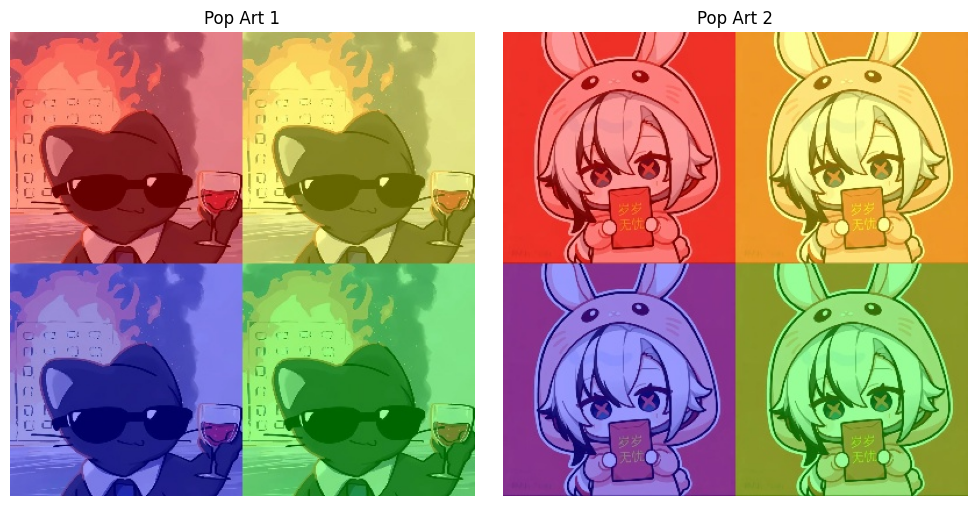

In [12]:
import cv2
import threading
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Caminhos das imagens
img_paths = [
    "imagens/future.jpeg",
    "imagens/Money.jpeg"
]

# Função para processar imagem
def processar_imagem(input_path, output_path, thread_name):
    inicio = datetime.now()
    print(f"[{inicio.strftime('%H:%M:%S')}] {thread_name} - Iniciando processamento de {input_path}")

    # Carregar e redimensionar
    img = cv2.imread(input_path)
    img = cv2.resize(img, (200, 200))  # tamanho padrão

    # Converter para cinza + máscara
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Paleta Pop Art
    color_maps = [
        (0, 0, 255),   # vermelho
        (0, 255, 255), # amarelo
        (255, 0, 0),   # azul
        (0, 255, 0)    # verde
    ]

    quadrantes = []
    for color in color_maps:
        # Cria cor sólida
        color_img = np.full_like(img, color, dtype=np.uint8)
        # Overlay semi-transparente
        result = cv2.addWeighted(img, 0.6, color_img, 0.4, 0)
        quadrantes.append(result)

    # Criar mosaico 2x2
    topo = np.hstack((quadrantes[0], quadrantes[1]))
    baixo = np.hstack((quadrantes[2], quadrantes[3]))
    final = np.vstack((topo, baixo))

    # Salvar resultado
    cv2.imwrite(output_path, final)

    fim = datetime.now()
    duracao = (fim - inicio).total_seconds()
    print(f"[{fim.strftime('%H:%M:%S')}] {thread_name} - Finalizou {input_path} em {duracao:.2f}s")

# Execução em Threads
threads = []
output_paths = []

for i, path in enumerate(img_paths):
    output_path = f"imagens/resultado_popart_{i+1}.jpg"
    output_paths.append(output_path)
    t = threading.Thread(target=processar_imagem, args=(path, output_path, f"Thread-{i+1}"))
    threads.append(t)
    t.start()

for t in threads:
    t.join()

print("\n✅ Processamento concluído!")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    img_resultado = cv2.cvtColor(cv2.imread(output_paths[i]), cv2.COLOR_BGR2RGB)
    axs[i].imshow(img_resultado)
    axs[i].set_title(f"Pop Art {i+1}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


# Parte 2 – Conexões Cliente-Servidor e Peer-to-Peer

Código Cliente-Servidor Multi-thread

In [13]:
import threading
import time
from queue import Queue

mensagens = Queue()
respostas = Queue()

lock = threading.Lock()
clientes_ativos = 0

def handle_client(client_id):
    """Simula a interação com um cliente."""
    global clientes_ativos
    with lock:
        clientes_ativos += 1
    print(f"[Conexão {client_id}] Cliente conectado. Ativos: {clientes_ativos}")

    while True:
        msg = mensagens.get()
        if msg == f"STOP-{client_id}":  # sinal de fim do cliente
            break
        print(f"[Cliente {client_id}] enviou: {msg}")
        resposta = f"Hello, Client {client_id}! Conexões ativas: {clientes_ativos}"
        respostas.put((client_id, resposta))
        time.sleep(1)

    with lock:
        clientes_ativos -= 1
    print(f"[Conexão {client_id}] Encerrada. Restam {clientes_ativos} clientes.\n")

def start_server(total_clientes=3):
    """Inicia o servidor e aguarda clientes simulados."""
    print("🚀 Servidor de mensagens iniciado...\n")
    threads = []

    for i in range(total_clientes):
        t = threading.Thread(target=handle_client, args=(i+1,))
        t.start()
        threads.append(t)
        time.sleep(0.5)  # intervalo

    return threads

threads_servidor = start_server(total_clientes=2)


🚀 Servidor de mensagens iniciado...

[Conexão 1] Cliente conectado. Ativos: 1
[Conexão 2] Cliente conectado. Ativos: 2


cliente

In [14]:
import time

def client_program(client_id, mensagens_enviadas):
    """Simula um cliente enviando mensagens ao servidor."""
    print(f"🤝 Cliente {client_id} conectado ao servidor simulado.")
    for msg in mensagens_enviadas:
        mensagens.put(msg)
        time.sleep(1)
        # Recebe resposta (bloqueia até ter resposta disponível)
        cid, resposta = respostas.get()
        if cid == client_id:
            print(f"📩 Cliente {client_id} recebeu: {resposta}")

    # encerramento do cliente
    mensagens.put(f"STOP-{client_id}")
    print(f"✅ Cliente {client_id} desconectado.\n")

t1 = threading.Thread(target=client_program, args=(1, ["Hello, Server!", "Como vai?", "Tchau!"]))
t2 = threading.Thread(target=client_program, args=(2, ["Olá, Servidor!", "Tudo bem?", "Até logo!"]))

t1.start()
t2.start()

t1.join()
t2.join()

print("\n🛑 Todas as conexões foram encerradas.")


🤝 Cliente 1 conectado ao servidor simulado.
[Cliente 1] enviou: Hello, Server!
🤝 Cliente 2 conectado ao servidor simulado.
[Cliente 2] enviou: Olá, Servidor!
📩 Cliente 1 recebeu: Hello, Client 1! Conexões ativas: 2
[Cliente 1] enviou: Como vai?
📩 Cliente 2 recebeu: Hello, Client 2! Conexões ativas: 2
[Cliente 2] enviou: Tudo bem?
📩 Cliente 1 recebeu: Hello, Client 1! Conexões ativas: 2
[Cliente 1] enviou: Tchau!
📩 Cliente 2 recebeu: Hello, Client 2! Conexões ativas: 2
[Cliente 2] enviou: Até logo!
📩 Cliente 1 recebeu: Hello, Client 1! Conexões ativas: 2
✅ Cliente 1 desconectado.

[Conexão 1] Encerrada. Restam 1 clientes.

📩 Cliente 2 recebeu: Hello, Client 2! Conexões ativas: 2
✅ Cliente 2 desconectado.

[Conexão 2] Encerrada. Restam 0 clientes.


🛑 Todas as conexões foram encerradas.


Código Peer-to-Peer (P2P)

In [15]:
from queue import Queue
import threading
import time

rede = Queue()
ativos = []
lock = threading.Lock()

class Node:
    """Cada nó atua como emissor e receptor (peer)."""
    def __init__(self, name):
        self.name = name
        self.alive = True
        ativos.append(self)
        self.thread = threading.Thread(target=self.listen)
        self.thread.start()

    def listen(self):
        """Thread que escuta mensagens da fila e mostra apenas as relevantes."""
        while self.alive:
            msg = rede.get()
            if msg == "STOP":
                break
            sender, texto = msg
            if sender != self.name:  # não exibe as próprias mensagens
                print(f"[{self.name} recebeu de {sender}] {texto}")
            time.sleep(0.2)

    def send(self, texto):
        """Envia mensagem à rede (broadcast)."""
        print(f"[{self.name} enviando] {texto}")
        rede.put((self.name, texto))

    def stop(self):
        """Finaliza o nó."""
        self.alive = False

nodeA = Node("Node A")
nodeB = Node("Node B")
nodeC = Node("Node C")

# Cada nó envia mensagens de forma concorrente
threading.Thread(target=nodeA.send, args=("Olá, sou o Node A!",)).start()
threading.Thread(target=nodeB.send, args=("Oi, aqui é o Node B!",)).start()
threading.Thread(target=nodeC.send, args=("Saudações do Node C!",)).start()

time.sleep(3)

# Encerramento
for n in ativos:
    n.stop()
rede.put("STOP")
print("\n🛑 Rede P2P finalizada.")


[Node A enviando] Olá, sou o Node A!
[Node B enviando] Oi, aqui é o Node B!
[Node C enviando] Saudações do Node C!

🛑 Rede P2P finalizada.


# Parte 3 – Sistema de Notificação Multicliente

### Servidor de Processamento de Imagem com Notificações

In [16]:
import threading, time
from queue import Queue

fila_notificacoes = Queue()
lock = threading.Lock()
clientes = []

def processar_pedido(client_id):
    """Simula o processamento de imagens de um cliente."""
    with lock:
        clientes.append(client_id)
    print(f"👤 [Cliente {client_id}] conectado ao servidor.")

    for i in range(1, 4):
        msg = f"🔄 [Cliente {client_id}] Processando imagem {i}..."
        fila_notificacoes.put(msg)
        time.sleep(1)

    # Finalização
    fim = f"✅ [Cliente {client_id}] Imagem processada!"
    fila_notificacoes.put(fim)

    with lock:
        clientes.remove(client_id)
    print(f"👋 [Cliente {client_id}] desconectado.\n")

def start_server():
    """Inicia o servidor e cria threads simulando múltiplos clientes."""
    print("🖥️ Servidor iniciado...\n")
    threads = []
    for i in range(3):
        t = threading.Thread(target=processar_pedido, args=(i+1,))
        t.start()
        threads.append(t)
        time.sleep(0.5)
    for t in threads:
        t.join()
    fila_notificacoes.put(None)  # fim das mensagens

threading.Thread(target=start_server).start()


🖥️ Servidor iniciado...

👤 [Cliente 1] conectado ao servidor.


### Cliente de Notificação

In [17]:
import time

def cliente_notificacao():
    """Cliente que consome notificações da fila."""
    print("📡 Cliente de Notificações iniciado...\n")
    while True:
        msg = fila_notificacoes.get()
        if msg is None:
            print("\n✅ Todas notificações recebidas. Cliente encerrado.")
            break
        print(msg)
        time.sleep(0.2)

cliente_notificacao()


📡 Cliente de Notificações iniciado...

🔄 [Cliente 1] Processando imagem 1...
👤 [Cliente 2] conectado ao servidor.
🔄 [Cliente 2] Processando imagem 1...
🔄 [Cliente 1] Processando imagem 2...
👤 [Cliente 3] conectado ao servidor.
🔄 [Cliente 3] Processando imagem 1...
🔄 [Cliente 2] Processando imagem 2...
🔄 [Cliente 1] Processando imagem 3...
🔄 [Cliente 3] Processando imagem 2...
🔄 [Cliente 2] Processando imagem 3...
👋 [Cliente 1] desconectado.
✅ [Cliente 1] Imagem processada!

🔄 [Cliente 3] Processando imagem 3...
👋 [Cliente 2] desconectado.
✅ [Cliente 2] Imagem processada!

👋 [Cliente 3] desconectado.

✅ [Cliente 3] Imagem processada!

✅ Todas notificações recebidas. Cliente encerrado.
